In [1]:
from tqdm import tqdm_notebook as tqdm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

trainA = plt.imread("Images/epoch004_real_A_raw.png")
trainB = plt.imread("Images/epoch004_real_B_raw.png")

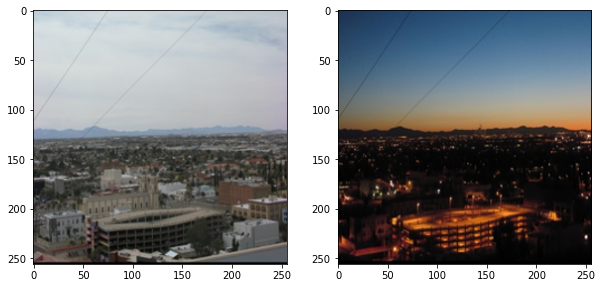

In [2]:
def change_range(img, max_val, min_val=0.):
    """ Rescales image value to [0, max_val].
    """
    rescaled = np.array(img) * (max_val - min_val) / 255. + min_val
    return np.rint(rescaled).astype(int)

def show_pair(pair):
#     plt.axis('off')
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(pair[0])
    plt.subplot(122)
    plt.imshow(pair[1])
    plt.show()
pair = (trainA, trainB)
show_pair(pair)

In [3]:
alpha = 0.5
sp = 100

In [4]:
def norm_numpy(x):
    x_min = x.min(axis=(0, 1), keepdims=True)
    x_max = x.max(axis=(0, 1), keepdims=True)
    out = (x - x_min) / (x_max - x_min + 1e-10)
    return out

In [5]:
import cv2

def gradient_field(img):
    img = np.float32(img)
    # grad = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    grad_y = cv2.Sobel(img,  cv2.CV_64F, 0, 1, ksize=3, borderType = cv2.BORDER_CONSTANT)
    grad_x = cv2.Sobel(img,  cv2.CV_64F, 1, 0, ksize=3, borderType = cv2.BORDER_CONSTANT)
    # grad_x = ndimage.sobel(img, axis=1)
    # grad_y = ndimage.sobel(img, axis=2)
    # grad = cv2.Laplacian(img,cv2.CV_64F,ksize=3)
    return np.stack([grad_x, grad_y], axis=0)

In [6]:
# gradient_field(trainA) - 

In [7]:
t1, t2 = 0.5, 0.2
A_rescaled = trainA * alpha
B_rescaled = trainB * t1 + t2
residual = B_rescaled - A_rescaled
clipped_residual = np.clip(residual, a_min=0, a_max=1. - alpha)
real_output = clipped_residual + A_rescaled


recon_loss_all = np.abs(gradient_field(trainB) - gradient_field(real_output))
random_mask = np.ones_like(recon_loss_all)
recon_loss = (recon_loss_all * random_mask).sum() / (random_mask.sum() + 1e-10)

residual_loss = (np.abs(clipped_residual - residual) * random_mask).mean()

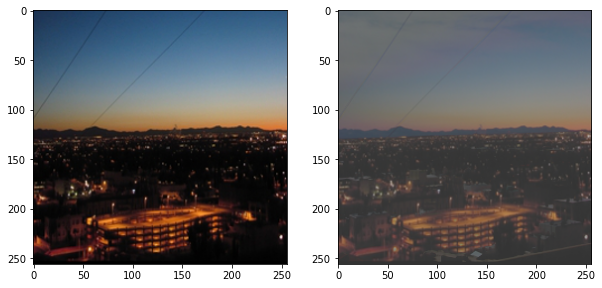

In [8]:
show_pair((trainB, real_output))

In [9]:
theta1s = np.linspace(0.0, 1.5, sp)
theta2s = np.linspace(-0.5, 1.0, sp)
T1s, T2s = np.meshgrid(theta1s, theta2s)

In [10]:
recon_losses_norm = np.zeros((sp, sp))
residual_losses_norm = np.zeros((sp, sp))

A_rescaled = trainA * alpha

for i, t1 in enumerate(theta1s):
    for j, t2 in enumerate(theta2s):
        
        B_rescaled = trainB * t1 + t2
        residual = B_rescaled - A_rescaled
        clipped_residual = np.clip(residual, a_min=0, a_max=1. - alpha)
        real_output = clipped_residual + A_rescaled

        recon_loss_all = np.abs(gradient_field(trainB) - gradient_field(real_output))
        random_mask = np.ones_like(recon_loss_all)
        recon_loss = (recon_loss_all * random_mask).sum() / (random_mask.sum() + 1e-10)

        residual_loss = (np.abs(clipped_residual - residual) * random_mask).mean()
        
        recon_losses_norm[j, i] = recon_loss
        residual_losses_norm[j, i] = residual_loss

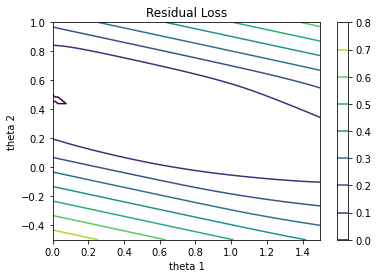

In [11]:
fig,ax=plt.subplots(1,1)
cp = ax.contour(T1s, T2s, residual_losses_norm)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Residual Loss')
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
plt.show()

In [12]:
import matplotlib
font = {
    'family' : 'Serif',
    'weight' : 'normal',
    'size'   : 14}
matplotlib.rc('font', **font)

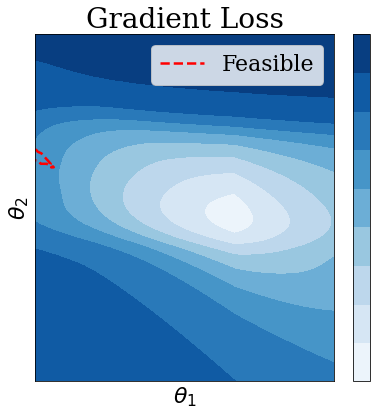

In [13]:
# levels=[0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.6]

fig,ax=plt.subplots(1,1, figsize=(6, 6))
cp = ax.contourf(T1s, T2s, recon_losses_norm, cmap="Blues") # , levels=levels)
CS = plt.contour(T1s,T2s,residual_losses_norm,levels=[1e-8], linestyles="dashed",colors='red', linewidths=2.5)
labels = ["Feasible"]
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])

plt.legend(loc='upper right', fontsize=22)


fig.colorbar(cp, ticks=[0, 0.2, 0.4]) # Add a colorbar to a plot
ax.set_title('Gradient Loss', fontsize=28)
ax.set_xlabel(r'$\theta_1$', fontsize=22)
ax.set_ylabel(r'$\theta_2$', fontsize=22)
plt.yticks([])
plt.xticks([])
plt.tight_layout()
# fig.savefig('l2-norm.png', dpi=100)
plt.show()

In [14]:
recon_losses_no = np.zeros((sp, sp))
residual_losses_no = np.zeros((sp, sp))

A_rescaled = trainA * alpha

for i, t1 in enumerate(theta1s):
    for j, t2 in enumerate(theta2s):
        
        B_rescaled = trainB * t1 + t2
        residual = B_rescaled - A_rescaled
        clipped_residual = np.clip(residual, a_min=0, a_max=1. - alpha)
        real_output = clipped_residual + A_rescaled

        recon_loss_all = np.abs(trainB - real_output)
        random_mask = np.ones_like(recon_loss_all)
        recon_loss = (recon_loss_all * random_mask).sum() / (random_mask.sum() + 1e-10)

#         residual_loss = (np.abs(clipped_residual - residual) * random_mask).mean()
        
        recon_losses_no[j, i] = recon_loss
#         residual_losses[j, i] = residual_loss

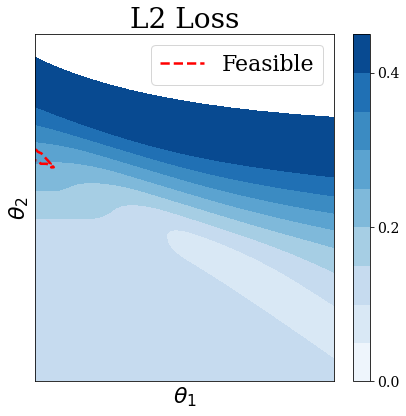

In [15]:
levels=[0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.5]

fig,ax=plt.subplots(1,1, figsize=(6, 6))
cp = ax.contourf(T1s, T2s, recon_losses_no, levels=levels, cmap=plt.cm.get_cmap('Blues'))

CS = plt.contour(T1s,T2s,residual_losses_norm,levels=[1e-8], linestyles="dashed",colors='red', linewidths=2.5)
labels = ["Feasible"]
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
    
plt.legend(loc='upper right', fontsize=22)
fig.colorbar(cp, ticks=[0, 0.2, 0.4]) # Add a colorbar to a plot
ax.set_title('L2 Loss', fontsize=28)
ax.set_xlabel(r'$\theta_1$', fontsize=22)
ax.set_ylabel(r'$\theta_2$', fontsize=22)
plt.yticks([])
plt.xticks([])
plt.tight_layout()
# fig.savefig('l2.png', dpi=100)
plt.show()